# Acceso datos del producto GRACE via SISSA

## Sistema de Información Sequías para el Sur de América del Sur (SISSA)

#### Jose Valles (jose.valles.leon@gmail.com)

# 1. Importar librerias

In [1]:
# Carga de paquetes Python necesarios para hacer los requests a la API y graficar resultados
import pathlib
import dateutil
import pandas.testing
import pandas.plotting
import requests
import requests.auth
import seaborn
import datetime
import os
import netCDF4
import json
import math
import numpy as np
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import rioxarray
import xarray as xr

from IPython.display import HTML

# 2. Definir funciones

In [2]:
# Definición de funciones globales, en lenguaje Python.

# Suprimir warnings cuando requests.get o requests.post
# son llamados con el paramétro verify igual a False)
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Función para acceder a un servicio web definido por una URL utilizando el método GET.
# Devuelve la respuesta como un pandas.DataFrame.
# El parámetro verify=False implica que no se va a verificar la velidéz del certifiado
# utilizado en la conexión SSL establecida con la API del CRC-SAS. Esto es útil cuando
# la máquina cliente no puede validar el ceritificado emitido por la CA del CRC-SAS.
def consumir_servicio_GET(url, usuario, clave):
    respuesta = requests.get(url=url, auth=requests.auth.HTTPBasicAuth(usuario, clave), verify=False)
    return respuesta

# Función para acceder a un servicio web definido por una URL utilizando el método POST.
# Devuelve la respuesta como un pandas.DataFrame.  
# El parámetro verify=False implica que no se va a verificar la velidéz del certifiado
# utilizado en la conexión SSL establecida con la API del CRC-SAS. Esto es útil cuando
# la máquina cliente no puede validar el ceritificado emitido por la CA del CRC-SAS.
def consumir_servicio_POST(url, usuario, clave, data):
    respuesta = requests.post(url=url, data=data, auth=requests.auth.HTTPBasicAuth(usuario, clave), verify=False)
    return respuesta

# Función para acceder a un servicio web definido por una URL utilizando
# un usuario y clave.
# Asumiendo que la respuesta es un string JSON, se hace la conversión
# de este string a un Data Frame.
def consumir_servicio_JSON(url, usuario, clave):
    respuesta = consumir_servicio_GET(url, usuario, clave)
    return pandas.json_normalize(respuesta.json())
    
# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en un área determinada.
# La respuesta se devuelve con un objeto de tipo raster.
def consumir_servicio_espacial(url, usuario, clave, archivo_geojson_zona, raster_var_tag):
    # a. Obtener datos y guardarlos en un archivo temporal (en memoria)
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. En lugar de abrir y leer un archivo, se leen los bytes recibidos
    archivo_nc = netCDF4.Dataset("in-mem-file", mode="r", memory=respuesta.content)

    # c. Obtener CRS y fechas del NetCDF
    nc_prj4string = archivo_nc.crs
    nc_start_date = np.array([dateutil.parser.isoparse(archivo_nc.start_date)])
    nc_variable = archivo_nc.variables.get('time')
    nc_fechas = netCDF4.num2date(nc_variable[:].flatten(), nc_variable.units) if nc_variable else nc_start_date
    nc_rasters = archivo_nc.variables.get(raster_var_tag)[:]  # rasters como variables netcdf

    # d. Borrar archivo temporal, liberar memoria
    archivo_nc.close()

    return nc_fechas, nc_rasters  # los rasters se devuelven como variables netcdf


# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en un área determinada.
# La respuesta se devuelve con un objeto de tipo xarray.
def consumir_servicio_espacial_xarray(url, usuario, clave, archivo_geojson_zona):
    # a. Obtener datos y guardarlos en un archivo temporal (en memoria)
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. En lugar de abrir y leer un archivo, se leen los bytes recibidos
    archivo_xr = xr.load_dataset(respuesta.content, engine='scipy')

    return archivo_xr  # se devuelve un objeto xarray


# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en puntos o un área determinada.
# La respuesta se devuelve con un Data Frame.
def consumir_servicio_espacial_serie_temporal(url, usuario, clave, archivo_geojson_zona):
    # a. Obtener datos y guardarlos en un archivo temporal
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. Leer respuesta y crear un dataframe
    datosJSON = respuesta.json()

    return pandas.io.json.json_normalize(datosJSON)  # se devuelve un dataframe

# 3. Credenciales

In [3]:
# base_url        = 'https://qc.smn.gob.ar/ws-api'
base_url        = 'https://api.crc-sas.org/ws-api'
usuario_default = 'jvallesleon'
clave_default   = 'jva135on'

# 4. Serie temporales de humedad de suelo - Producto GRACE

Los productos resultantes de la misión GRACE (Gravity Recovery and Climate Experiment) - que forma parte de un proyecto conjunto entre la NASA (https://www.nasa.gov/) y la Agencia Espacial Alemana (https://www.dlr.de), abordan una de las carencias más importantes de los sistemas de monitoreo de sequía: “la falta de información objetiva acerca de humedad de suelo en capas profundas y los niveles de napa subterránea”.

A partir del modelo de captación de superficie terrestre (CLSM – [24]) se han definido tres variables relevantes para el monitoreo de la sequía: humedad superficial del suelo (surface soil moisture – SFSM), humedad del suelo en la zona de raíces (root zone soil moisture – RTZSM) y almacenamiento de agua subterránea (groundwater storage – GWS). Estos tres productos están disponibles en el sitio https://nasagrace.unl.edu/ con frecuencia semanal y datos desde febrero de 2003 hasta la fecha.

Las variables que se pueden extraer son: 
* **gws_inst:** Groundwater Percentile (Contenido de agua subterránea, expresado en percentiles)
* **rtzsm_inst:** Root Zone Soil Moisture Percentile (Humedad del suelo en zona de raíces, expresada en percentiles)
* **sfsm_inst:** Surface Soil Moisture Percentile (Humedad superficial del suelo, expresada en percentiles)

In [4]:
# Buscar GRACE para la fecha indicada en las variables fecha_desde y fecha_hasta y una ubicación en
grace_variable = "sfsm_inst"

fecha_desde = dateutil.parser.parse("2022-03-02").isoformat()
fecha_hasta = dateutil.parser.parse("2023-03-02").isoformat()

# define the URL for downloading the Grace products
url_grace = f"{base_url}/grace/serie_temporal/{grace_variable}/{fecha_desde}/{fecha_hasta}"

In [5]:
# Define points for downloading the data
punto_geojson = "data/puntos_uruguay.geojson"
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_grace,usuario=usuario_default,clave=clave_default,archivo_geojson_zona=punto_geojson)

C:\Users\DINAGUA\AppData\Local\Temp\ipykernel_15644\1880021380.py:83: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  return pandas.io.json.json_normalize(datosJSON)  # se devuelve un dataframe


In [6]:
display(serie_temporal.head(6))

,NOMBRE,id,fecha,valor
0,Florida,1,2022-03-07,80.8820
1,Florida,1,2022-03-14,43.2403
2,Florida,1,2022-03-21,34.1518
3,Florida,1,2022-03-28,62.4317
4,Florida,1,2022-04-04,42.6898
5,Florida,1,2022-04-11,87.7197


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


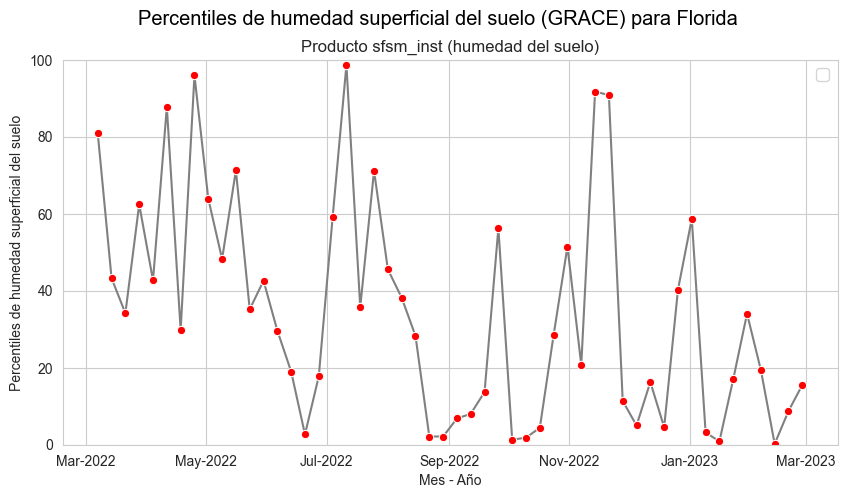

In [7]:
# Serie temporal
serie_temporal['fecha'] = pd.to_datetime(serie_temporal.fecha);
#
plt.figure(figsize=(10, 5));
plt.suptitle('Percentiles de humedad superficial del suelo (GRACE) para Florida', fontsize='x-large');

seaborn.set_style('whitegrid');
ax = seaborn.lineplot(x=serie_temporal.fecha, y=serie_temporal.valor, color="grey", marker="o", mec="white", mfc="red");

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'));
ax.set_ylim([0,100]);
# ax.set_xbound(lower=datetime.date(2010, 12, 1), upper=datetime.date(2022, 1, 31))

ax.set_title('Producto sfsm_inst (humedad del suelo)', fontsize='large');
ax.set_xlabel('Mes - Año');
ax.set_ylabel('Percentiles de humedad superficial del suelo');
ax.legend(fontsize='large', ncol=4);

plt.show();


# 5. Serie Temporales de humedad de suelo en un área - Producto GRACE

In [8]:
zona_geojson = "data/cuenca_nivel2.geojson"
serie_temporal = consumir_servicio_espacial_serie_temporal(url=url_grace,
                                                           usuario=usuario_default, clave=clave_default,
                                                           archivo_geojson_zona=zona_geojson)


C:\Users\DINAGUA\AppData\Local\Temp\ipykernel_15644\1880021380.py:83: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  return pandas.io.json.json_normalize(datosJSON)  # se devuelve un dataframe


In [9]:
serie_temporal['fecha'] = pd.to_datetime(serie_temporal.fecha);

In [10]:
codcuenca = 61
# selecting rows based on condition
cuenca_grace = serie_temporal[serie_temporal['codcuenca'] == codcuenca]

In [11]:
# Serie temporal
cuenca_grace = cuenca_grace.query("estadistico in ['0%', '50%', '100%']")

In [12]:
HTML(cuenca_grace.head(6).to_html(index=False))

area,codcuenca,nombrec2,popup,cabecera,estadistico,fecha,valor
2570,61,RIO SANTA LUCIA CHICO,RÍO SANTA LUCÍA CHICO,61,0%,2022-03-07,79.4633
2570,61,RIO SANTA LUCIA CHICO,RÍO SANTA LUCÍA CHICO,61,50%,2022-03-07,80.4019
2570,61,RIO SANTA LUCIA CHICO,RÍO SANTA LUCÍA CHICO,61,100%,2022-03-07,80.8820
2570,61,RIO SANTA LUCIA CHICO,RÍO SANTA LUCÍA CHICO,61,0%,2022-03-14,41.9632
2570,61,RIO SANTA LUCIA CHICO,RÍO SANTA LUCÍA CHICO,61,50%,2022-03-14,42.6886
2570,61,RIO SANTA LUCIA CHICO,RÍO SANTA LUCÍA CHICO,61,100%,2022-03-14,43.2403


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


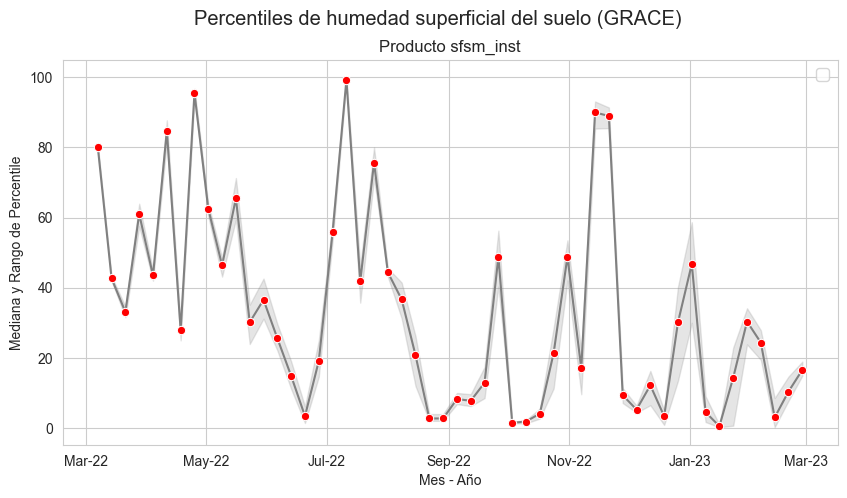

In [13]:
plt.figure(figsize=(10, 5))
plt.suptitle('Percentiles de humedad superficial del suelo (GRACE)', fontsize='x-large')

seaborn.set_style('whitegrid')
ax = seaborn.lineplot(x=cuenca_grace.fecha, y=cuenca_grace.valor, color="grey",marker="o", mec="white", mfc="red")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.set_title('Producto sfsm_inst', fontsize='large')
ax.set_xlabel('Mes - Año')
ax.set_ylabel('Mediana y Rango de Percentile')
ax.legend(fontsize='large', ncol=4)

plt.show()
#


# 6. Serie Temporales de humedad de suelo en un área - Producto GRACE

In [26]:
fecha_desde = dateutil.parser.parse("2023-02-02").isoformat()
fecha_hasta = dateutil.parser.parse("2023-03-02").isoformat()

url_grace = f"{base_url}/grace/{grace_variable}/{fecha_desde}/{fecha_hasta}"
zona_geojson = "data/uruguay.geojson"

fechas, grace_xr = consumir_servicio_espacial(url=url_grace, usuario=usuario_default, clave=clave_default,
                                             archivo_geojson_zona=zona_geojson,raster_var_tag='sfsm_inst')



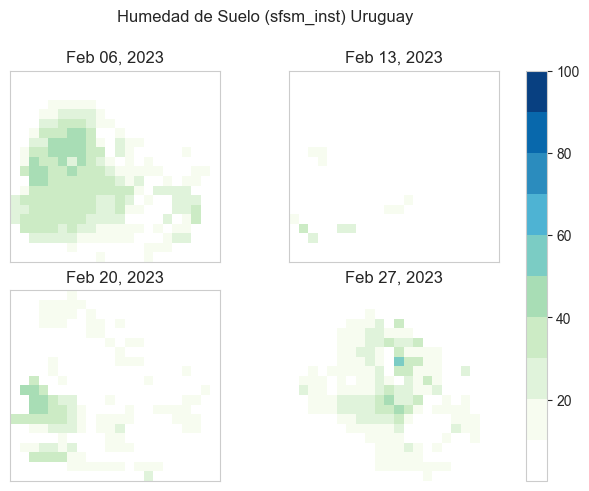

In [31]:
zona_gdf = gpd.read_file(zona_geojson)
myColors = ['#ffffff','#F7FCF0','#E0F3DB','#CCEBC5','#A8DDB5','#7BCCC4','#4EB3D3','#2B8CBE','#0868AC','#084081']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
# Graficar rasters de ESI
figure, axes = plt.subplots(nrows=math.ceil(len(fechas)/2), ncols=1+(1%len(fechas)), 
                            constrained_layout=True)
_ = figure.suptitle('Humedad de Suelo (sfsm_inst) Uruguay\n')

for ax, fecha, raster in zip(figure.get_axes(), fechas, grace_xr):
    __ = ax.set_title(fecha.strftime("%b %d, %Y")), ax.set_xticks([]), ax.set_yticks([])
    im = ax.imshow(raster if len(grace_xr) > 1 else grace_xr, vmin=grace_xr.min(), vmax=100, cmap = cmap)

_ = figure.colorbar(im, ax=figure.get_axes())

plt.axis('off')
plt.show()